<a href="https://www.kaggle.com/code/emmermarcell/traffic-sign-recognition-with-kerascv?scriptVersionId=157939286" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data challenge

Your task is to build an algorithm for prohibitory traffic sign recognition. We have
created a training data set (20 images) that can be used for building and fine-tuning a model.
However, you are encouraged to collect more images, since it will allow you to improve your
model’s performance.

There are 6 traffic sign categories your model should be able to recognize:
* Category A - no right, left, or U-turn
* Category B - speed limit (regardless of the indicated value)
* Category C - road closed
* Category D - no entry
* Category E - no stopping, no parking
* Category F - other types of prohibitory traffic signs

## Here we will to implement the [YOLOv8][1] model in KerasCV, an extension of Keras for Computer Vision

We'll follow this tutorial:

https://keras.io/examples/vision/yolov8/

For reference here are some other notebooks that use this model on Kaggle. For some reason all of them have japanese comments but the code is understandable.

https://www.kaggle.com/code/sumtony/keras-cv-yolov8-obj-detection?scriptVersionId=155201062

https://www.kaggle.com/code/cliheng/keras-cv-yolov8-object-detection

A great resource for image augmentation using KerasCV:

https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/

[1]: https://keras.io/api/keras_cv/models/backbones/yolo_v8/

## For training and validation we'll use the mapillary dataset that was preprcessed and augmented by Izabell Járó.

The train and test sets are combined for training in our case, while the validation set is used for validation.

Our test set will the the 20 images provided by the traffic sign data challenge.


In [1]:
# You need THIS version of keras-cv in order fo the code to work
!pip install keras-cv==0.6.4
!pip install keras-nlp==0.6.3
!pip install -U pycocotools    # Official APIs for the MS-COCO dataset, the backbone of our model i.e. the dataset it was trained on.

  Obtaining dependency information for keras-cv==0.6.4 from https://files.pythonhosted.org/packages/be/4c/a45de94dcaa533bdf1dce1643321d57452c79e7b581c9d573facf10c7118/keras_cv-0.6.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 13.4 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: keras-cv
    Found existing installation: keras-cv 0.8.0.dev0
    Uninstalling keras-cv-0.8.0.dev0:
      Successfully uninstalled keras-cv-0.8.0.dev0
  Obtaining dependency information for keras-nlp==0.6.3 from https://files.pythonhosted.org/packages/16/37/e2bdca1975d3e5ebafb63dfcddc3b55369e012763f63abd7699dae8c0a45/keras_nlp-0.6.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 12.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras-nlp
    Found existing installation: keras-nlp 0.7.0.dev3
    Uninstalling keras-nlp-0.7.0.dev3:
      Successfully uninstalled keras-nlp-0.7.0.dev3
  Obtaining dependency information for pycocotool

In [2]:
# List the versions of keras for reproducibility
!pip list | grep keras

keras                                    2.13.1
keras-core                               0.1.7
keras-cv                                 0.6.4
keras-nlp                                0.6.3
keras-tuner                              1.3.5


In [3]:
# See available GPUs
!nvidia-smi

Sat Jan  6 16:19:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
# Import packages
import os
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import keras_cv
from keras_cv import bounding_box, visualization
import wandb    # For reference: https://docs.wandb.ai/tutorials/keras
from wandb.keras import WandbMetricsLogger
from kaggle_secrets import UserSecretsClient
from pprint import pprint


# Set tensorflow backend for keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Use the available GPUs for training our model (The T100 GPU that Kaggle provides)
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend
DEVICES AVAILABLE: 1


In [5]:
# Track hyperparameters
config = {
        # Random seed
        "seed": 42,
        # For loading in the images
        "num_classes": 6,
        "image_size": 640,
        "image_channels": 3,
        "batch_size": 20,    # 4
        "bbox_format": "xyxy",
        # Size of the training set (max is 26714), set to 'all' if you need all
        "train_size": 100,
        # For the prediction decoder
        "iou_threshold": 0.2,
        "confidence_threshold": 0.7,
        # For the Adam optimizer
        "learning_rate": 0.001,
        "global_clipnorm": 10.0,
        # For freezing layers (max is 169 for yolo_v8_s_backbone_coco)
        'freeze_layers': 152,
        # For evaluating the BoxCOCOMetrics
        'eval_freq': 1e9,
        # For fitting the model
        "num_epochs": 10,
        "early_stopping_patience": 5,
        "log_frequency": 5,
}


# Set the random seed for reproducibility
keras.utils.set_random_seed(seed=config['seed'])

# Use Weights & Biases for logging
user_secrets = UserSecretsClient()
wandb_key = user_secrets.get_secret("wandb_key")

wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load in the Traffic Sign Data from the Data Challenge as a Test set

In [6]:
# Set the path to the folder containing the training images
path_images = '/kaggle/input/traffic-signs-data-challenge/train'

# Set the class ids
class_ids = [
    'no-right-left-or-u-turn',
    'speed-limit',
    'road-closed',
    'no-entry',
    'no-stopping-no-parking',
    'other'
]

# Create a dictionary mapping the class ids to integers
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'no-right-left-or-u-turn',
 1: 'speed-limit',
 2: 'road-closed',
 3: 'no-entry',
 4: 'no-stopping-no-parking',
 5: 'other'}

In [7]:
# Read the annotation file into a pandas dataframe
annot_file = '/kaggle/input/traffic-signs-data-challenge/train/_annotations.csv'
annot_df = pd.read_csv(annot_file)

annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,no-entry,22,149,60,177
1,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,no-stopping-no-parking,520,160,570,198
2,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,other,522,236,571,274
3,6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg,600,300,road-closed,506,121,542,153
4,6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg,600,300,other,555,97,597,131


In [8]:
# Group the annotations by filename and aggregate the class ids into a list
test_df = annot_df.groupby(['filename']).agg({col:lambda x: list(x) for col in annot_df.columns[1:]}).reset_index()

test_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,10_jpg.rf.73da5bf11a250d18d212bd276be2a02e.jpg,"[600, 600, 600]","[300, 300, 300]","[road-closed, no-stopping-no-parking, speed-li...","[211, 515, 515]","[175, 107, 68]","[240, 557, 555]","[203, 143, 104]"
1,11_jpg.rf.788b737ab908f716125157158a741b1d.jpg,"[600, 600]","[300, 300]","[no-stopping-no-parking, no-entry]","[543, 6]","[67, 112]","[600, 42]","[142, 146]"
2,12_jpg.rf.f2fd7c2e462831e1225e480312289ad9.jpg,"[600, 600]","[300, 300]","[speed-limit, no-stopping-no-parking]","[521, 524]","[147, 186]","[556, 556]","[177, 214]"
3,13_jpg.rf.d5301f84fec055b793adabfb5e4ef329.jpg,"[600, 600, 600]","[300, 300, 300]","[speed-limit, other, no-stopping-no-parking]","[431, 432, 430]","[149, 120, 91]","[459, 460, 460]","[176, 149, 120]"
4,14_jpg.rf.b69dd2f82bdc031b0ccd416aaa8ffaf5.jpg,"[600, 600, 600]","[300, 300, 300]","[other, other, speed-limit]","[463, 456, 319]","[104, 158, 124]","[487, 496, 327]","[158, 213, 134]"


In [9]:
def parse_annotation_csv(row, img_path):
    """
    Function to parse the annotation csv file
    :param row: Current row of the annotation csv file
    :img_path: Path to the image folder containing the images
    :return: Image path, bounding boxes, and class ids
    """
    # Get the path of the image
    image_name = row['filename']
    image_path = os.path.join(img_path, image_name)
    
    # Get the bounding box of the traffic sign
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']
    
    # Combine coordinates into a list
    boxes = [[xmin[i], ymin[i], xmax[i], ymax[i]] for i in range(len(xmin))]
    
    # Get the class id of the traffic sign
    classes = row['class']
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    
    return image_path, boxes, class_ids

def create_ragged_tensor_from_df(df, img_path):
    """
    Function to create a ragged tensor from the DataFrame
    :param df: DataFrame to convert
    :img_path: Path to the image folder containing the images
    :return: A Tensflow ragged tensor
    """
    # Initialize lists to store information
    image_paths, bbox, classes = [], [], []
    # Process annotations for each row in the DataFrame
    for index, row in df.iterrows():
        image_path, boxes, class_ids = parse_annotation_csv(row, img_path)

        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)
        
    print('image_paths first 10')
    pprint(image_paths[:10])
    print('bbox first 10')
    pprint(bbox[:10])
    print('classes first 10')
    pprint(classes[:10])
    # Ragged tensors are used to create a tf.data.Dataset using 
    # the from_tensor_slices method. This method creates a dataset 
    # from the input tensors by slicing them along the first dimension. 
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)
    # Create a dataset from the ragged tensors
    data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    
    return data


test_data = create_ragged_tensor_from_df(test_df, path_images)

image_paths first 10
['/kaggle/input/traffic-signs-data-challenge/train/10_jpg.rf.73da5bf11a250d18d212bd276be2a02e.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/11_jpg.rf.788b737ab908f716125157158a741b1d.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/12_jpg.rf.f2fd7c2e462831e1225e480312289ad9.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/13_jpg.rf.d5301f84fec055b793adabfb5e4ef329.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/14_jpg.rf.b69dd2f82bdc031b0ccd416aaa8ffaf5.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/15_jpg.rf.162c7db1dc3d488435d85966979936da.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/16_jpg.rf.12b7ef37dd31287b55ace3deb5eaf975.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/18_jpg.rf.7f567daed1f036392e4c88d133258cb1.jpg',
 '/kaggle/input/traffic-signs-data-challenge/train/19_jpg.rf.b5ae2cd88323133d23

# Load in the Mapillary data as a Train and Validation set

In [10]:
mapillary_img_path = '/kaggle/input/mapillary-labels/images/images'

# Read the annotation file into a pandas dataframe
mapillary_annot_file = '/kaggle/input/mapillary-labels/object_all.csv'

# Load in the .csv file
mapillary_df = pd.read_csv(mapillary_annot_file, usecols=[1,2,3,4,5,6,7,8])
# rename the name column to filename
mapillary_df.rename(columns={'name': 'filename'}, inplace=True)
# Rename filenames that end with '_aug' to end with '_augreduced' and add '.jpg'
mapillary_df.replace(to_replace=r'_aug$', value='_augreduced', regex=True, inplace=True)
mapillary_df['filename'] = mapillary_df['filename'] + '.jpg'
# The boundig box coordinates need to be integers
mapillary_df[['xmin', 'ymin', 'xmax', 'ymax']] = mapillary_df[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)

mapillary_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,hzlM917YtiazVQzFBL8kCw_3819_augreduced.jpg,4032,3024,road-closed,621,2752,679,2845
1,HcYl32I27DcQPFISMtgacw_3748_augreduced.jpg,4032,3024,road-closed,2968,1259,3124,1416
2,5EMpP9GmwHDBQz8YcZ3_oQ_2289_augreduced.jpg,4032,3024,road-closed,2231,993,2404,1159
3,9wyk0xrm1mdAu3C3GbVlqQ_2500_augreduced.jpg,3264,2448,road-closed,2331,1849,2477,1988
4,zUfI8ZBn02wK2VTzv6GgvQ_2240_augreduced.jpg,5248,3936,road-closed,3731,953,3781,1019


In [11]:
mapillary_grouped_df = mapillary_df.groupby(['filename']).agg({col:lambda x: list(x) for col in annot_df.columns[1:]}).reset_index()

mapillary_grouped_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,--7fWq6WjZM8L1eUSuvOEA.jpg,[4160],[3120],[other],[1480],[1327],[1576],[1421]
1,--7fWq6WjZM8L1eUSuvOEA_1475_augreduced.jpg,[4160],[3120],[other],[1334],[1302],[1427],[1382]
2,--7fWq6WjZM8L1eUSuvOEA_177_augreduced.jpg,[4160],[3120],[other],[2215],[1044],[2330],[1149]
3,-0G6gt8ksR0hO5jMKrTDMw.jpg,[4032],[3024],[no-entry],[1776],[1932],[1800],[1956]
4,-0oqTZyDwf6SJlJXaHSTVg.jpg,[3840],[2160],[no-entry],[1267],[890],[1305],[951]


In [12]:
# Read the list of filenames from the validation.txt file
# Replace 'validation.txt' with the actual path to your txt file
val_pics_path = '/kaggle/input/mapillary-labels/validation.txt'

with open(val_pics_path, 'r') as file:
    validation_filenames = [line.strip()+'.jpg' for line in file]
    
val_df = mapillary_grouped_df[mapillary_grouped_df['filename'].isin(validation_filenames)]
train_df = mapillary_grouped_df[~mapillary_grouped_df['filename'].isin(validation_filenames)]

In [13]:
train_df.info()
print('='*40)
val_df.info()
print('='*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26714 entries, 0 to 27635
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  26714 non-null  object
 1   width     26714 non-null  object
 2   height    26714 non-null  object
 3   class     26714 non-null  object
 4   xmin      26714 non-null  object
 5   ymin      26714 non-null  object
 6   xmax      26714 non-null  object
 7   ymax      26714 non-null  object
dtypes: object(8)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 922 entries, 8 to 27624
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  922 non-null    object
 1   width     922 non-null    object
 2   height    922 non-null    object
 3   class     922 non-null    object
 4   xmin      922 non-null    object
 5   ymin      922 non-null    object
 6   xmax      922 non-null    object
 7   ymax      922 non-null    obj

In [14]:
# Check if we use all of the training images
if config['train_size'] == 'all':
    train_data = create_ragged_tensor_from_df(train_df, mapillary_img_path)
# If not then use the fist n that are less than all the training images
elif isinstance(config['train_size'], int) and config['train_size'] <= len(train_df):
    train_data = create_ragged_tensor_from_df(train_df.head(config['train_size']), mapillary_img_path)    # The size of the training set can be changed in  the config (max is 26714) 
else:
    raise ValueError('Size of the traininng set inside the config is invalid.')
val_data = create_ragged_tensor_from_df(val_df, mapillary_img_path)

image_paths first 10
['/kaggle/input/mapillary-labels/images/images/--7fWq6WjZM8L1eUSuvOEA.jpg',
 '/kaggle/input/mapillary-labels/images/images/--7fWq6WjZM8L1eUSuvOEA_1475_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/--7fWq6WjZM8L1eUSuvOEA_177_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0G6gt8ksR0hO5jMKrTDMw.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg_1629_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg_188_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-0oqTZyDwf6SJlJXaHSTVg_3070_augreduced.jpg',
 '/kaggle/input/mapillary-labels/images/images/-1dYvHaY52PTrihdjPDPQg.jpg',
 '/kaggle/input/mapillary-labels/images/images/-1dYvHaY52PTrihdjPDPQg_1943_augreduced.jpg']
bbox first 10
[[[1480, 1327, 1576, 1421]],
 [[1334, 1302, 1427, 1382]],
 [[2215, 1044, 2330, 1149]],
 [[1776, 1932, 1800, 195

In [15]:
def load_image(image_path):
    """
    Function to load the image
    :param image_path: Path to the image
    :return: Tensorflow tensor of the image
    """
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=config['image_channels'])
    return image

def load_dataset(image_path, classes, bbox):
    """
    Function to load the dataset into a dictionary
    :param image_path: Path to the image
    :param classes: List of class ids
    :param bbox: List of bounding boxes
    :return: Dictionary containing the image and bounding boxes as float32 tensors
    """
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


## "Augmentation" with the Natie KerasCV methods that are aware of the bounding boxes.
It doesn't create more images it just transforms the original ones

In [16]:
# Create an augmenter using the KerasCV layers for the training set
augmenter = keras.Sequential(
    layers=[
        # Randomly flip the image horizontally
        keras_cv.layers.RandomFlip(
            mode="horizontal", bounding_box_format=config["bbox_format"]
        ),
        # Randomly shear the image
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format=config["bbox_format"]
        ), 
        # Randomly zoom into the image
        keras_cv.layers.JitteredResize(
            target_size=(config['image_size'], config['image_size']),
            scale_factor=(0.75, 1.3), bounding_box_format=config["bbox_format"]
        ),
    ]
)

# Create a resizer layer for the validation and test sets
resizer = keras_cv.layers.Resizing(
    config['image_size'],
    config['image_size'],
    pad_to_aspect_ratio=True,
    bounding_box_format=config["bbox_format"],
)

jittered_resizer = keras_cv.layers.JitteredResize(
    target_size=(config['image_size'], config['image_size']),
    scale_factor=(0.75, 1.3),
    bounding_box_format=config["bbox_format"],
)

## Creating Training Validation and Test Dataset

In [17]:
def preprocess_dataset(data, preprocessor):
    """
    Function to preprocess the dataset
    :param data: Dataset to preprocess
    :param preprocessor: Preprocessing layer to apply
    :return: Preprocessed dataset
    """
    # Load the dataset
    dataset = data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    # Shuffle the dataset
    dataset = dataset.shuffle(config['batch_size'] * 4)
    # Batch the dataset
    dataset = dataset.ragged_batch(config['batch_size'], drop_remainder=True)
    # Augment the dataset
    dataset = dataset.map(preprocessor, num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset

# We don't need to use the "augmenter" sequetial model, since the training data is already augmented
train_ds = preprocess_dataset(train_data, resizer)
val_ds = preprocess_dataset(val_data, resizer)
test_ds = preprocess_dataset(test_data, resizer)

## Visualization of the training dataset

### Some examples of the augmented training data. All the images are reshaped into 640x640 pixels with this letterboxing technique that fills the remeining part of the image black.

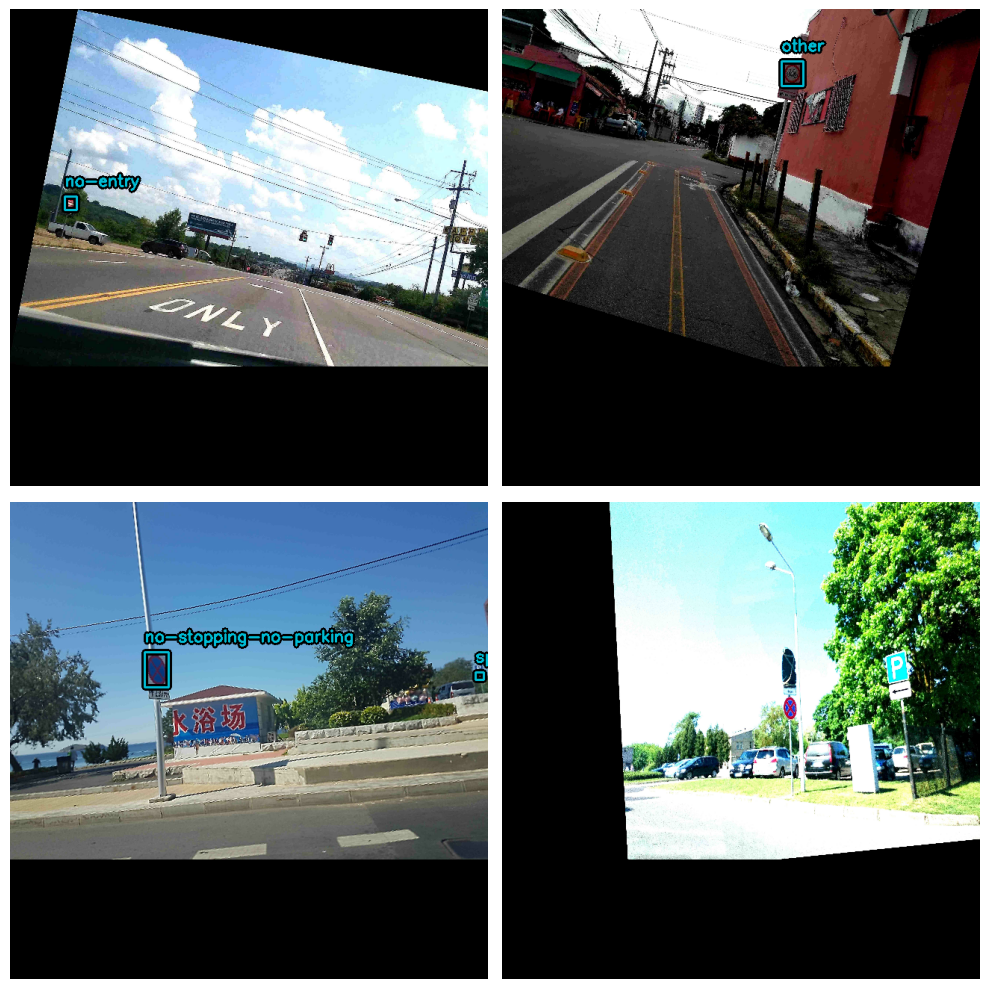

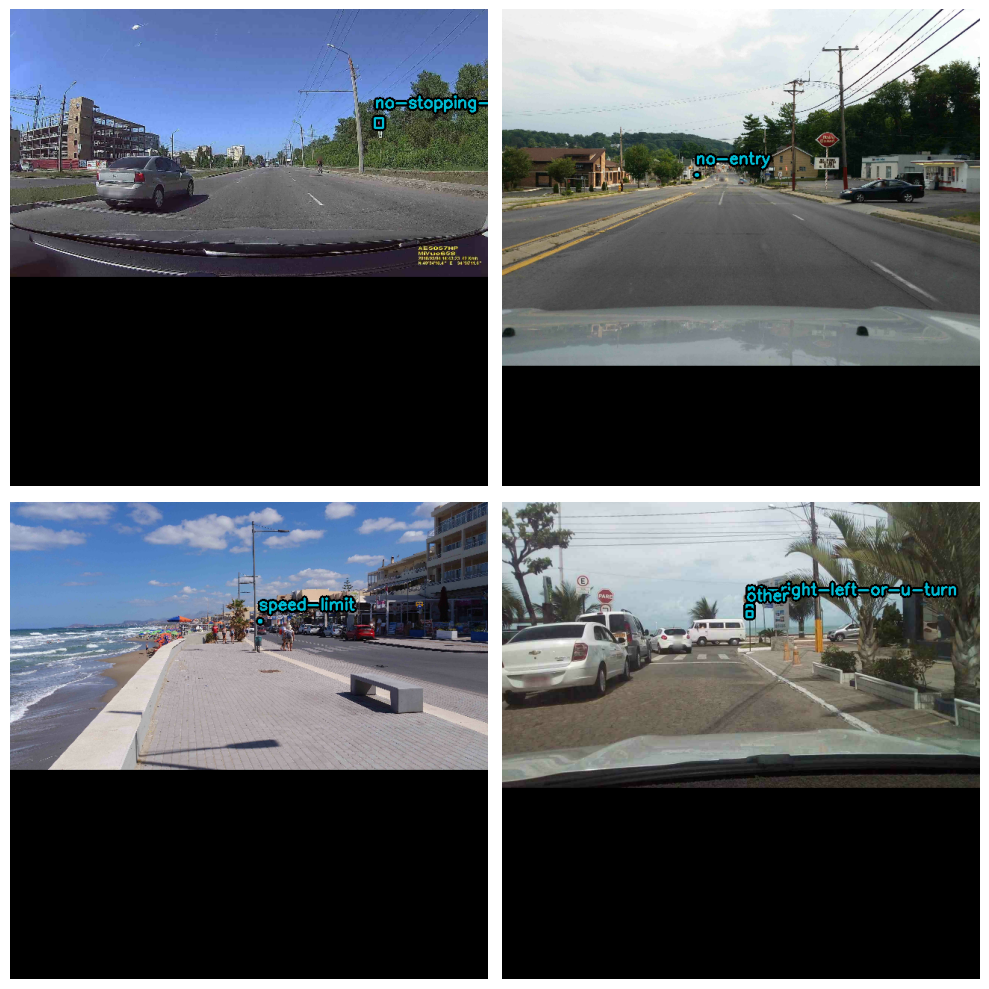

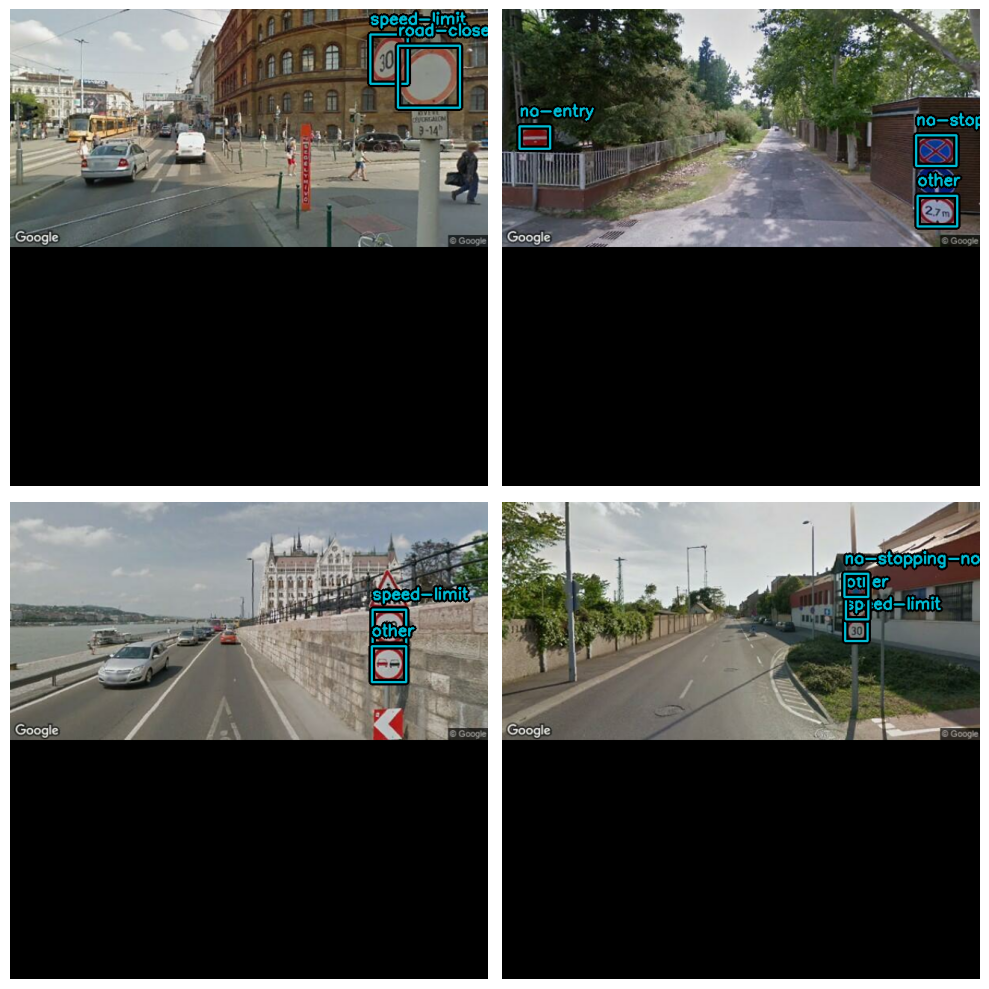

In [18]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    """
    Function to visualize the dataset
    :param inputs: Dataset to visualize
    :param value_range: Range of values to plot
    :param rows: Number of rows in the plot
    :param cols: Number of columns in the plot
    :param bounding_box_format: Format of the bounding boxes
    """
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

visualize_dataset(
    train_ds, bounding_box_format=config["bbox_format"], value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format=config["bbox_format"], value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    test_ds, bounding_box_format=config["bbox_format"], value_range=(0, 255), rows=2, cols=2
)

In [19]:
def dict_to_tuple(inputs):
    """
    Function to convert the dictionary to a tuple
    :param inputs: Dictionary to convert
    :return: Tuple containing the image and bounding boxes
    """
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

# Implementing the YOLOv8 model in Keras

In [20]:
 def build_model():
    """
    Builds the yolo model from the yolo_v8_s_coco backbone
    :return: yolo model with the first 150 layers frozen
    """
    # For transfer learning, we load the YOLOv8 weights trained on the COCO dataset
    backbone = keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_s_backbone_coco"
    )    # A small YOLOV8 backbone with 5.09 million parameters. Ref: https://keras.io/api/keras_cv/models/backbones/yolo_v8/


    prediction_decoder = keras_cv.layers.NonMaxSuppression(
        bounding_box_format=config["bbox_format"],
        from_logits=True,
        # Decrease the required threshold to make predictions get pruned out
        iou_threshold=config['iou_threshold'],
        # Tune confidence threshold for predictions to pass NMS
        confidence_threshold=config['confidence_threshold'],
    )

    yolo = keras_cv.models.YOLOV8Detector(
        backbone=backbone,
        num_classes=config['num_classes'],    # The number of neurons in the last layer
        bounding_box_format=config["bbox_format"],
        fpn_depth=1,
        prediction_decoder=prediction_decoder,
    )

    optimizer = Adam(
        learning_rate=config['learning_rate'],
        global_clipnorm=config['global_clipnorm'],
    )

    # Freeze the first 150 layers out of the 169
    for layer in yolo.layers[:config['freeze_layers']]:
        layer.trainable=False

    yolo.compile(
        optimizer=optimizer,
        classification_loss="binary_crossentropy",
        box_loss="ciou",
    )    # User metrics is not supported yet for yolov8 so we have to create a callback class for it
    # This mean that we can just write e.g.  metrics=['acccuracy'], inside the compile call
    
    return yolo

In [21]:
# A variable created under a MirroredStrategy is a MirroredVariable
# Therefore the notebook will use GPUs for training the model defined here
with strategy.scope():
    yolo = build_model()

yolo.summary()

20596968/20596968 [==============================] - 0s 0us/step
Model: "yolov8_detector"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 model (Functional)          {'P3': (None, None, None,    5089760   ['input_2[0][0]']             
                             128),                                                                
                              'P4': (None, None, None,                                            
                             256),                                                                
                              'P5': (None, None, None,                                            
                   

## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves.

In [22]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        """
        Method to initialize the callback
        :param data: Dataset to evaluate
        :param save_path: Path to save the model
        """
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format=config["bbox_format"],
            evaluate_freq=config['eval_freq'],
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        """
        Method to evaluate the model on the validation set
        :param epoch: Current epoch
        :param logs: Dictionary containing the logs
        :return: Dictionary containing the logs
        """
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [23]:
run = wandb.init(
    # Set the project where this run will be logged
    project="traffic-sign-recognition-with-kerascv",
    # Track hyperparameters and run metadata
    config=config,
)

# Run the wandb magic comand!
# This displays an embedding of the wandb run
%wandb

yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=config['num_epochs'],
    callbacks=[
        EarlyStopping(patience=config['early_stopping_patience'], verbose=1),
        EvaluateCOCOMetricsCallback(val_ds, "model.h5"),
        WandbMetricsLogger(log_freq=config['log_frequency']),
    ],
)

wandb: Currently logged in as: emmermarci (import_this). Use `wandb login --relogin` to force relogin


Epoch 1/10
5/5 [==============================] - ETA: 0s - loss: 31257.0176 - box_loss: 6.7621 - class_loss: 31250.2559

UnknownError: {{function_node __wrapped__EagerPyFunc_Tin_1_Tout_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_46_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [20,2,4] vs. shape[1] = [20,7,4] [Op:ConcatV2] name: concat
Traceback (most recent call last):

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 266, in __call__
    return func(device, token, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 144, in __call__
    outputs = self._call(device, args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 151, in _call
    ret = self._func(*args)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 643, in wrapper
    return func(*args, **kwargs)

  File "/opt/conda/lib/python3.10/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 203, in result_on_host_cpu
    return tf.constant(obj_result(force), obj.dtype)

  File "/opt/conda/lib/python3.10/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 254, in result
    self._cached_result = self._compute_result()

  File "/opt/conda/lib/python3.10/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 262, in _compute_result
    _box_concat(self.ground_truths),

  File "/opt/conda/lib/python3.10/site-packages/keras_cv/src/metrics/object_detection/box_coco_metrics.py", line 44, in _box_concat
    result[key] = tf.concat([b[key] for b in boxes], axis=0)

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/util/traceback_utils.py", line 153, in error_handler
    raise e.with_traceback(filtered_tb) from None

  File "/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/ops.py", line 6656, in raise_from_not_ok_status
    raise core._status_to_exception(e) from None  # pylint: disable=protected-access

tensorflow.python.framework.errors_impl.InvalidArgumentError: {{function_node __wrapped__ConcatV2_N_46_device_/job:localhost/replica:0/task:0/device:CPU:0}} ConcatOp : Dimension 1 in both shapes must be equal: shape[0] = [20,2,4] vs. shape[1] = [20,7,4] [Op:ConcatV2] name: concat

 [Op:EagerPyFunc] name: 

## Visualize detections

In [ ]:
# Load the best model
yolo = keras.models.load_model('model.h5', compile=False)

def visualize_detections(model, dataset, bounding_box_format):
    """
    Function to visualize the detections
    :param model: Model to use for prediction
    :param dataset: Dataset to visualize
    :param bounding_box_format: Format of the bounding boxes
    """
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

visualize_detections(yolo, dataset=test_ds, bounding_box_format=config["bbox_format"])

# Evaluation on the Test set

[Source][1]

[1]: https://towardsdatascience.com/object-detection-using-retinanet-and-kerascv-b07940327b6c

In [ ]:
# only consider boxes with areas less than a 128x128 square.
coco_metrics = keras_cv.metrics.BoxCOCOMetrics(
    bounding_box_format=config["bbox_format"], evaluate_freq=1
)

# Evaluate the model on the test set
images, y_true = next(iter(test_ds.take(num_test))) 
y_pred = yolo.predict(images)             # Predict the bounding boxes
y_pred = bounding_box.to_ragged(y_pred)   # Convert the bounding boxes to ragged tensors

coco_metrics.update_state(y_true, y_pred) # Update the state of the metric
results = coco_metrics.result(force=True) # Get the results of the metric
results

In [ ]:
results['MaP'].numpy()

In [ ]:
# log the evaluationm metrics
for key, value in results.items():
    run.log({'test_'+key: value.numpy()})
    
# Close the W&B run
run.finish()